# SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=7.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=82.000, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=50.496, Time=1.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=4.56 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=80.125, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=80.100, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=49.020, Time=2.21 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=5.63 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=57.475, Time=1.33 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=33.172, Time=1.93 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=33.739, Time=1.52 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=24.850, Time=5.27 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=4.41 sec
 ARIMA(2,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=6.86 sec


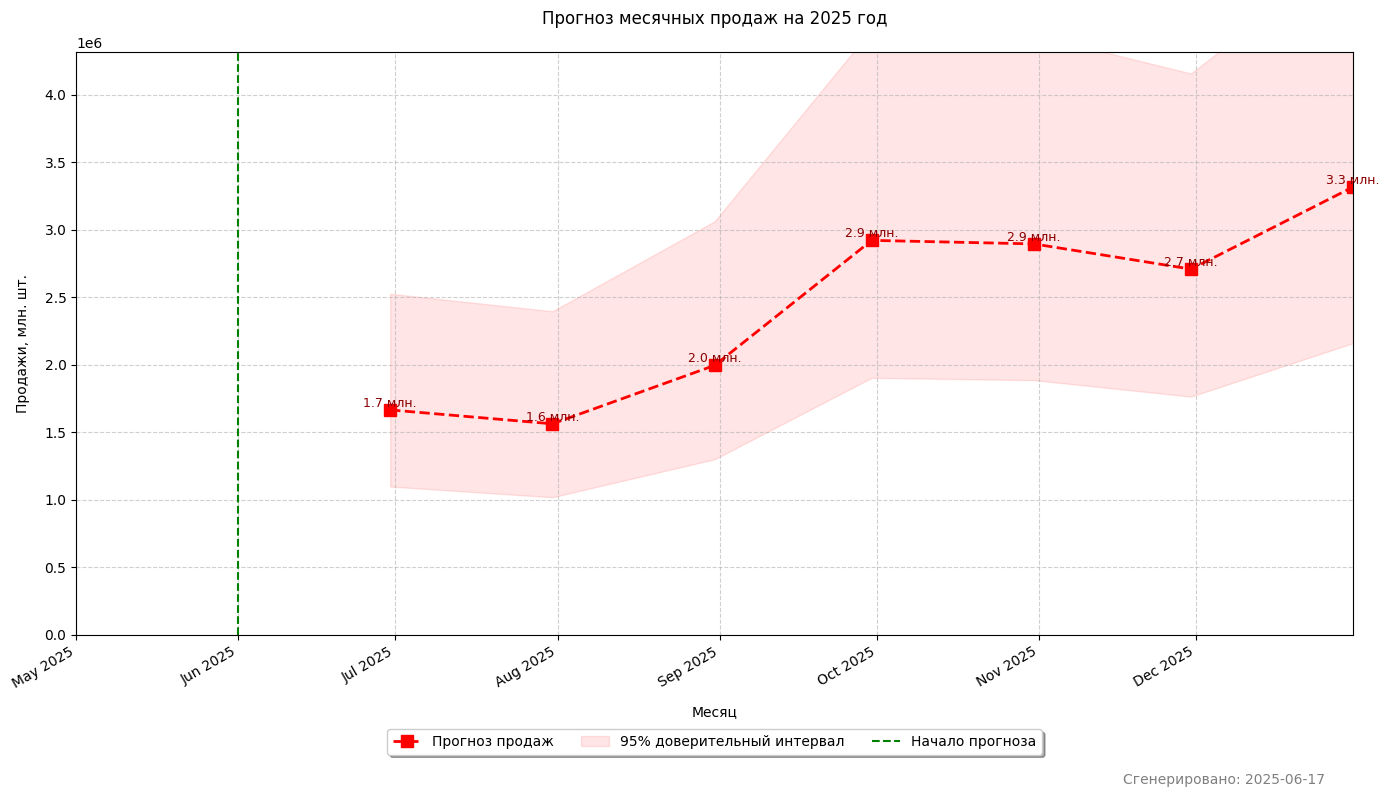


Детальный прогноз на 2025 год:
  Месяц  Прогноз (млн. шт.)  Нижняя граница (млн. шт.)  Верхняя граница (млн. шт.)
2025-06                 1.7                        1.1                         2.5
2025-07                 1.6                        1.0                         2.4
2025-08                 2.0                        1.3                         3.1
2025-09                 2.9                        1.9                         4.5
2025-10                 2.9                        1.9                         4.4
2025-11                 2.7                        1.8                         4.2
2025-12                 3.3                        2.2                         5.1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from datetime import datetime
import matplotlib.dates as mdates
from pmdarima import auto_arima

warnings.filterwarnings('ignore')

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff = diff[np.isfinite(diff)]
    return round(np.mean(diff) * 100, 1)

# 1. Загрузка и подготовка данных
df = pd.read_excel('../data/sales.xlsx')
df.columns = ['date', 'item', 'sales']
df['date'] = pd.to_datetime(df['date'])

# Агрегация по месяцам
df_monthly = df.groupby(pd.Grouper(key='date', freq='ME'))['sales'].sum().reset_index()

# Создание полного временного ряда
current_date = datetime.now().strftime("%Y-%m-%d")
last_actual_date = pd.to_datetime(current_date)
full_dates = pd.date_range(start=df_monthly['date'].min(), end=last_actual_date, freq='ME')
df_full = pd.DataFrame({'date': full_dates})
df_full = df_full.merge(df_monthly, on='date', how='left')
df_full['sales'] = df_full['sales'].fillna(0)
df_full = df_full.set_index('date')

# 2. Определение периодов
forecast_start = df_full.index[-1] + pd.offsets.MonthBegin(1)
forecast_end = pd.to_datetime("2025-12-31")

# 3. Построение модели
y_train = np.log1p(df_full['sales'])

# Автоподбор параметров SARIMA
model = auto_arima(y_train,
                  seasonal=True,
                  m=12,
                  stepwise=True,
                  trace=True,
                  suppress_warnings=True,
                  error_action='ignore')

print(f"Лучшие параметры модели: {model.order}, {model.seasonal_order}")

# 4. Прогнозирование
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='ME')
steps = len(forecast_dates)

# Прогноз с доверительными интервалами
forecast_result = model.predict(n_periods=steps, return_conf_int=True)
forecast_values = np.expm1(forecast_result[0])
conf_int = np.expm1(forecast_result[1])

# 5. Визуализация только прогнозных данных
plt.figure(figsize=(14, 8))

# Явно задаем границы оси X
x_min = forecast_start - pd.DateOffset(months=1)  # Добавляем небольшой отступ слева
x_max = forecast_end

# Прогноз с маркерами
line = plt.plot(forecast_dates, forecast_values, 'r--s',
               label='Прогноз продаж', linewidth=2, markersize=8)

# Доверительный интервал
plt.fill_between(forecast_dates,
                conf_int[:, 0],
                conf_int[:, 1],
                color='red', alpha=0.1, label='95% доверительный интервал')

# Добавляем подписи значений (в млн. шт.)
for date, value in zip(forecast_dates, forecast_values):
    plt.text(date, value, f'{value/1_000_000:.1f} млн.',
            ha='center', va='bottom', fontsize=9, color='darkred')

# Вертикальная линия начала прогноза
plt.axvline(x=forecast_start, color='green', linestyle='--',
           linewidth=1.5, label='Начало прогноза')

# Форматирование оси X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

# Настройка осей
plt.xlim(x_min, x_max)
y_padding = max(forecast_values.max() * 0.1, 1_000_000)
plt.ylim(0, forecast_values.max() + y_padding)

# Настройки графика
plt.title('Прогноз месячных продаж на 2025 год', pad=20)
plt.xlabel('Месяц', labelpad=10)
plt.ylabel('Продажи, млн. шт.', labelpad=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Легенда
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=3, frameon=True, shadow=True)

# Подпись
plt.figtext(0.95, 0.01, f'Сгенерировано: {current_date}',
           ha='right', va='bottom', alpha=0.5)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

# Вывод прогнозируемых значений в млн.
forecast_df = pd.DataFrame({
    'Месяц': forecast_dates.strftime('%Y-%m'),
    'Прогноз (млн. шт.)': (forecast_values/1_000_000).round(1),
    'Нижняя граница (млн. шт.)': (conf_int[:, 0]/1_000_000).round(1),
    'Верхняя граница (млн. шт.)': (conf_int[:, 1]/1_000_000).round(1)
})
print("\nДетальный прогноз на 2025 год:")
print(forecast_df.to_string(index=False))